# 99 - Modelo Solución Final - Pruebas Saber Pro Colombia

## Descripción

Este notebook contiene la **solución completa** que se envió a Kaggle para la competencia de predicción de rendimiento en las Pruebas Saber Pro Colombia.

**Modelo Principal:** CatBoost Classifier

**Pipeline:**
1. Carga de datos (train.csv y test.csv)
2. Feature Engineering (indicadores y categóricas)
3. Entrenamiento del modelo CatBoost con manejo nativo de categóricas
4. Validación y evaluación
5. Generación del archivo submission_catboost.csv para Kaggle


---
## 1. Configuración e Importaciones


In [5]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Preprocesamiento
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Modelo CatBoost
from catboost import CatBoostClassifier

# Métricas de evaluación
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Configuración
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("="*80)
print("CATBOOST CON CATEGÓRICAS NATIVAS")
print("="*80)
print("✓ Librerías cargadas correctamente")


CATBOOST CON CATEGÓRICAS NATIVAS
✓ Librerías cargadas correctamente


---
## 2. Carga de Datos


In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_ids = test['ID'].copy()

print("="*80)
print("DIMENSIONES DE LOS DATOS")
print("="*80)
print(f"Train: {train.shape}")
print(f"Test: {test.shape}")


DIMENSIONES DE LOS DATOS
Train: (692500, 21)
Test: (296786, 20)


---
## 3. Feature Engineering


In [7]:
ind_cols = ['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']

def create_features(df):
    df = df.copy()
    for col in ind_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df['RATIO_1_2'] = df['INDICADOR_1'] / (df['INDICADOR_2'] + 0.001)
    df['DIFF_1_2'] = df['INDICADOR_1'] - df['INDICADOR_2']
    df['SUMA_IND'] = df[ind_cols].sum(axis=1)
    df['MAX_IND'] = df[ind_cols].max(axis=1)
    df['STD_IND'] = df[ind_cols].std(axis=1)
    df['PROP_IND1'] = df['INDICADOR_1'] / (df['SUMA_IND'] + 0.001)
    return df

train = create_features(train)
test = create_features(test)

train['PROG_DEPT'] = train['E_PRGM_ACADEMICO'].astype(str) + '_' + train['E_PRGM_DEPARTAMENTO'].astype(str)
test['PROG_DEPT'] = test['E_PRGM_ACADEMICO'].astype(str) + '_' + test['E_PRGM_DEPARTAMENTO'].astype(str)

print("✓ Features creadas")


✓ Features creadas


---
## 4. Preprocesamiento


In [8]:
y = train['RENDIMIENTO_GLOBAL']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

drop_cols = ['ID', 'PERIODO_ACADEMICO', 'RENDIMIENTO_GLOBAL', 'F_TIENEINTERNET.1']
X = train.drop([c for c in drop_cols if c in train.columns], axis=1)
X_test_final = test.drop([c for c in drop_cols if c in test.columns], axis=1)

cat_cols = X.select_dtypes(include=['object']).columns.tolist()

for col in cat_cols:
    X[col] = X[col].fillna('MISSING').astype(str)
    X_test_final[col] = X_test_final[col].fillna('MISSING').astype(str)

num_cols = X.select_dtypes(include=[np.number]).columns
X[num_cols] = X[num_cols].fillna(X[num_cols].median())
X_test_final[num_cols] = X_test_final[num_cols].fillna(X[num_cols].median())

print(f"Features: {X.shape[1]}, Categóricas: {len(cat_cols)}")


Features: 24, Categóricas: 14


---
## 5. Train/Validation Split


In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded
)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}")


Train: (554000, 24), Validation: (138500, 24)


---
## 6. Entrenamiento CatBoost


In [10]:
print("="*80)
print("ENTRENAMIENTO CATBOOST")
print("="*80)

model = CatBoostClassifier(
    iterations=800,
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=3,
    border_count=128,
    random_seed=RANDOM_STATE,
    verbose=100,
    cat_features=cat_cols,
    task_type='CPU',
    early_stopping_rounds=50
)

model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
print("\n✓ Entrenamiento completado")


ENTRENAMIENTO CATBOOST
0:	learn: 1.3727581	test: 1.3725128	best: 1.3725128 (0)	total: 1.14s	remaining: 15m 8s
100:	learn: 1.1984873	test: 1.1941467	best: 1.1941467 (100)	total: 1m 36s	remaining: 11m 8s
200:	learn: 1.1912170	test: 1.1880152	best: 1.1880152 (200)	total: 3m 24s	remaining: 10m 10s
300:	learn: 1.1874833	test: 1.1854958	best: 1.1854958 (300)	total: 5m 13s	remaining: 8m 39s
400:	learn: 1.1852061	test: 1.1843471	best: 1.1843471 (400)	total: 7m 3s	remaining: 7m 1s
500:	learn: 1.1836094	test: 1.1837483	best: 1.1837483 (500)	total: 8m 53s	remaining: 5m 18s
600:	learn: 1.1822317	test: 1.1833283	best: 1.1833283 (600)	total: 10m 47s	remaining: 3m 34s
700:	learn: 1.1810050	test: 1.1830337	best: 1.1830337 (700)	total: 12m 38s	remaining: 1m 47s
799:	learn: 1.1798790	test: 1.1828042	best: 1.1828042 (799)	total: 14m 28s	remaining: 0us

bestTest = 1.182804229
bestIteration = 799


✓ Entrenamiento completado


---
## 7. Evaluación


In [13]:
train_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)

print("="*80)
print("RESULTADOS")
print("="*80)
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Overfitting Gap: {train_acc - val_acc:.4f}")


RESULTADOS
Train Accuracy: 0.4534
Validation Accuracy: 0.4440
Overfitting Gap: 0.0094


In [14]:
y_val_pred = model.predict(X_val)
print(classification_report(y_val, y_val_pred, target_names=le.classes_))


              precision    recall  f1-score   support

        alto       0.58      0.63      0.60     35124
        bajo       0.48      0.57      0.52     34597
  medio-alto       0.33      0.30      0.32     34324
  medio-bajo       0.33      0.27      0.30     34455

    accuracy                           0.44    138500
   macro avg       0.43      0.44      0.43    138500
weighted avg       0.43      0.44      0.44    138500



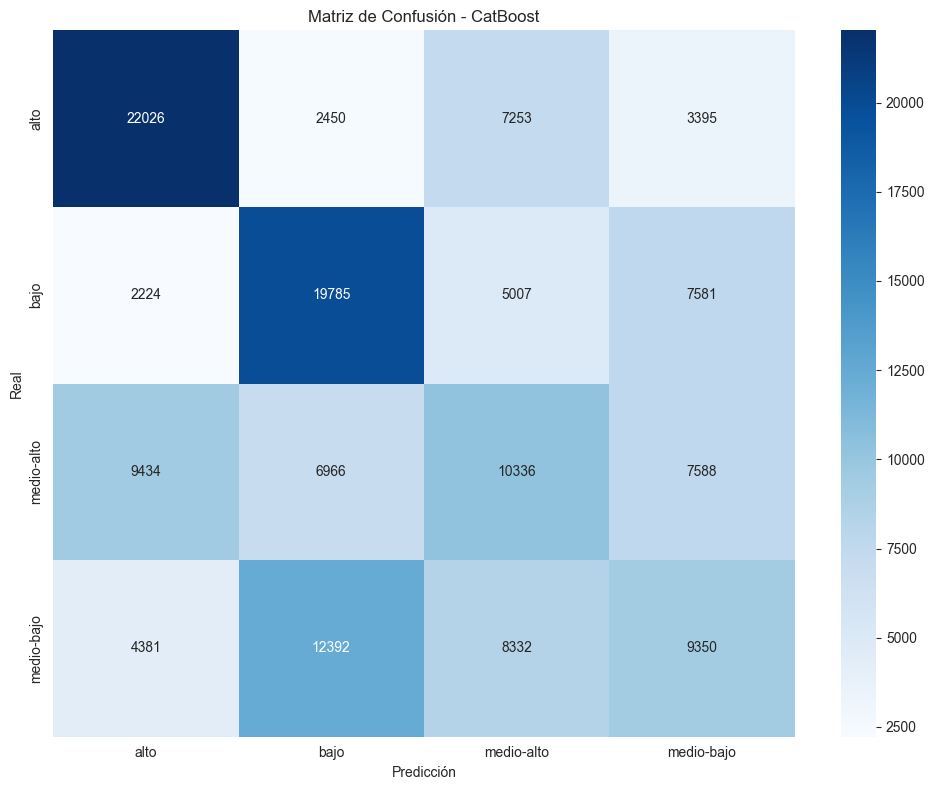

In [15]:
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión - CatBoost')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()


TOP 15 FEATURES:
                    feature  importance
                  PROG_DEPT   37.133579
E_VALORMATRICULAUNIVERSIDAD   20.875294
           F_EDUCACIONMADRE    5.988689
           E_PRGM_ACADEMICO    5.134652
       E_HORASSEMANATRABAJA    5.046340
           F_EDUCACIONPADRE    4.810939
        E_PRGM_DEPARTAMENTO    4.412984
      E_PAGOMATRICULAPROPIO    3.241577
          F_ESTRATOVIVIENDA    2.997600
          F_TIENECOMPUTADOR    2.174887
            F_TIENEINTERNET    1.876539
            F_TIENELAVADORA    1.628431
           F_TIENEAUTOMOVIL    1.177406
                INDICADOR_2    0.524651
                INDICADOR_4    0.494997


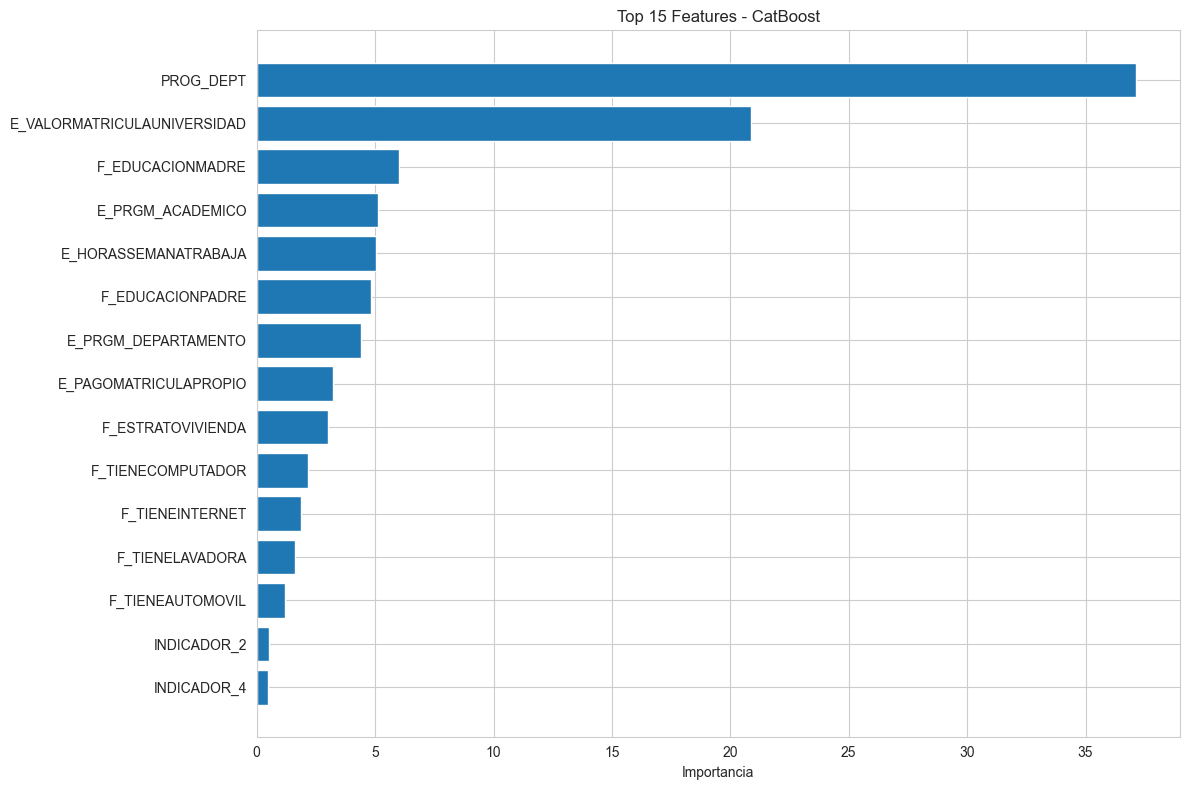

In [16]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("TOP 15 FEATURES:")
print(feature_importance.head(15).to_string(index=False))

plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importancia')
plt.title('Top 15 Features - CatBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


---
## 8. Generación Submission Kaggle


In [17]:
y_test_pred = model.predict(X_test_final)
y_test_pred_labels = le.inverse_transform(y_test_pred.flatten().astype(int))

submission = pd.DataFrame({
    'ID': test_ids,
    'RENDIMIENTO_GLOBAL': y_test_pred_labels
})

print("Primeras filas:")
print(submission.head(10))
print(f"\nDistribución:")
print(submission['RENDIMIENTO_GLOBAL'].value_counts().sort_index())


Primeras filas:
       ID RENDIMIENTO_GLOBAL
0  550236               bajo
1   98545         medio-bajo
2  499179               alto
3  782980               bajo
4  785185               bajo
5   58495               bajo
6  705444               alto
7  557548               alto
8  519909               bajo
9  832058               alto

Distribución:
RENDIMIENTO_GLOBAL
alto          81394
bajo          89947
medio-alto    65710
medio-bajo    59735
Name: count, dtype: int64


In [18]:
submission.to_csv('submission_catboost.csv', index=False)

print("="*80)
print("✅ SUBMISSION GENERADO")
print("="*80)
print(f"Archivo: submission_catboost.csv")
print(f"Registros: {len(submission):,}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"\n🚀 ¡Listo para Kaggle!")


✅ SUBMISSION GENERADO
Archivo: submission_catboost.csv
Registros: 296,786
Validation Accuracy: 0.4440

🚀 ¡Listo para Kaggle!


## Resultados Destacados

### Métricas del Modelo
- **Accuracy en Validación:** 44.4%
- **Accuracy en Entrenamiento:** 45.3%
- **Gap de Overfitting:** 0.94% (excelente generalización)
- **Dataset Entrenamiento:** 692,500 registros
- **Dataset Test:** 296,786 registros

### Performance por Clase
| Clase | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| alto | 0.58 | 0.63 | 0.60 | 35,124 |
| bajo | 0.48 | 0.57 | 0.52 | 34,597 |
| medio-alto | 0.33 | 0.30 | 0.32 | 34,324 |
| medio-bajo | 0.33 | 0.27 | 0.30 | 34,455 |

### Top 5 Features Más Importantes
1. **PROG_DEPT** - 37.13% (Combinación programa-departamento)
2. **E_VALORMATRICULAUNIVERSIDAD** - 20.88% (Valor de matrícula)
3. **F_EDUCACIONMADRE** - 5.99% (Educación de la madre)
4. **E_PRGM_ACADEMICO** - 5.13% (Programa académico)
5. **E_HORASSEMANATRABAJA** - 5.05% (Horas de trabajo semanal)